In [1]:
%cd ..

/home/jovyan/workspace/models/instance-segmentation/yolov7-seg


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import yaml
from torchvision import transforms
from utils.augmentations import letterbox
from utils.general import non_max_suppression

/home/jovyan/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# with open('data/hyp.scratch.mask.yaml') as f:
#     hyp = yaml.load(f, Loader=yaml.FullLoader)
weigths = torch.load("./weights/yolov7-seg.pt")
model = weigths["model"]
model = model.half().to(device)
_ = model.eval()

In [135]:
# image = cv2.imread("./inference/images/bus.jpg")
# image = cv2.imread("./inference/images/horses.jpg")
# image = cv2.imread("./inference/images/image1.jpg")
# image = cv2.imread("./inference/images/image2.jpg")
# image = cv2.imread("./inference/images/image3.jpg")
image = cv2.imread("./inference/images/zidane.jpg")

In [136]:
image = letterbox(image, 640, stride=64, auto=False)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))
image = image.to(device)
image = image.half()

# Mask has same shape with image, plot by mul

In [137]:
pred, out = model(image)
proto = out[1]
pred.shape, proto.shape

(torch.Size([1, 25200, 117]), torch.Size([1, 32, 160, 160]))

In [138]:
conf_thres = 0.35
iou_thres = 0.65
max_det = 100

det = non_max_suppression(
    pred, conf_thres, iou_thres, None, False, max_det=max_det, nm=32
)[0]
print(det.shape)

torch.Size([3, 38])


In [139]:
det_bbox = det[:, :4]
det_conf = det[:, 4]
det_cls = det[:, 5]
det_mask = det[:, 6:]

det_bbox.shape, det_conf.shape, det_cls.shape, det_mask.shape

(torch.Size([3, 4]), torch.Size([3]), torch.Size([3]), torch.Size([3, 32]))

In [140]:
protos = proto[0].clone()
masks_in = det_mask.clone()
shape = image.shape[2:]
bboxes = det_bbox.clone()
print(shape)

c, mh, mw = protos.shape  # CHW
ih, iw = shape
masks = (masks_in @ protos.float().view(c, -1)).sigmoid().view(-1, mh, mw)  # CHW
print(masks.shape)

torch.Size([640, 640])
torch.Size([3, 160, 160])


In [141]:
downsampled_bboxes = bboxes.clone()
downsampled_bboxes[:, 0] *= mw / iw
downsampled_bboxes[:, 2] *= mw / iw
downsampled_bboxes[:, 3] *= mh / ih
downsampled_bboxes[:, 1] *= mh / ih
print(downsampled_bboxes.shape)

boxes = downsampled_bboxes

# Crop
n, h, w = masks.shape
x1, y1, x2, y2 = torch.chunk(boxes[:, :, None], 4, 1)  # x1 shape(1,1,n)
r = torch.arange(w, device=masks.device, dtype=x1.dtype)[
    None, None, :
]  # rows shape(1,w,1)
c = torch.arange(h, device=masks.device, dtype=x1.dtype)[
    None, :, None
]  # cols shape(h,1,1)
masks = masks * ((r >= x1) * (r < x2) * (c >= y1) * (c < y2))
print(masks.shape)

# Upsample
masks = F.interpolate(masks[None], shape, mode="bilinear", align_corners=False)[
    0
]  # CHW
print(masks.shape)

# Threshold
masks = masks.gt_(0.5)
print(masks.shape)

torch.Size([3, 4])
torch.Size([3, 160, 160])
torch.Size([3, 640, 640])
torch.Size([3, 640, 640])


In [142]:
# masks = masks[:, :, :, None]
# masks = masks.repeat(1, 1, 1, 3)
# print(masks.shape)

In [143]:
masks, det_bbox, det_cls, det_conf = (
    masks.cpu().numpy(),
    det_bbox.cpu().numpy(),
    det_cls.cpu().numpy(),
    det_conf.cpu().numpy(),
)
masks = masks.astype(np.bool)

In [144]:
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

In [145]:
pnimg = nimg.copy()
print(pnimg.shape)

(640, 640, 3)


In [146]:
for one_mask, bbox, cls, conf in zip(masks, det_bbox, det_cls, det_conf):
    if conf < 0.25:
        continue

    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5

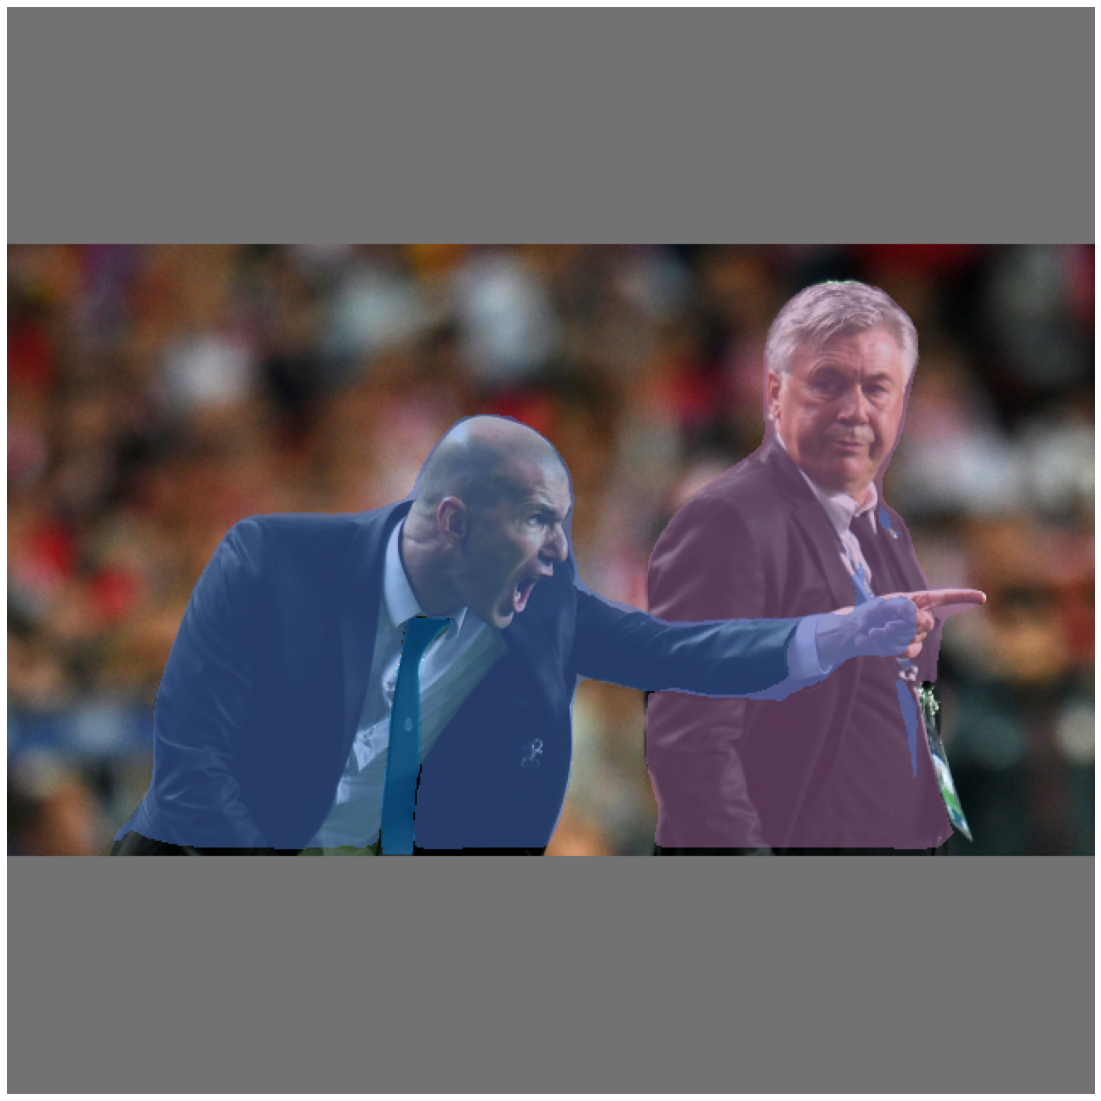

In [147]:
# coco example
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(pnimg)
plt.show()

# Mask has same shape with proto + crop and resize to mask_resolution

In [26]:
pred, out = model(image)
proto = out[1]
pred.shape, proto.shape

(torch.Size([1, 25200, 117]), torch.Size([1, 32, 160, 160]))

In [27]:
conf_thres = 0.35
iou_thres = 0.65
max_det = 100

det = non_max_suppression(
    pred, conf_thres, iou_thres, None, False, max_det=max_det, nm=32
)[0]
print(det.shape)

torch.Size([6, 38])


In [28]:
det_bbox = det[:, :4]
det_conf = det[:, 4]
det_cls = det[:, 5]
det_mask = det[:, 6:]

det_bbox.shape, det_conf.shape, det_cls.shape, det_mask.shape

(torch.Size([6, 4]), torch.Size([6]), torch.Size([6]), torch.Size([6, 32]))

In [29]:
protos = proto[0].clone()
masks_in = det_mask.clone()
shape = image.shape[2:]
bboxes = det_bbox.clone()
print(shape)

c, mh, mw = protos.shape  # CHW
ih, iw = shape
masks = (masks_in @ protos.float().view(c, -1)).sigmoid().view(-1, mh, mw)  # CHW
print(masks.shape)

torch.Size([640, 640])
torch.Size([6, 160, 160])


In [30]:
downsampled_bboxes = bboxes.clone()
downsampled_bboxes[:, 0] *= mw / iw
downsampled_bboxes[:, 2] *= mw / iw
downsampled_bboxes[:, 3] *= mh / ih
downsampled_bboxes[:, 1] *= mh / ih
print(downsampled_bboxes.shape)

boxes = downsampled_bboxes

# Crop
n, h, w = masks.shape
x1, y1, x2, y2 = torch.chunk(boxes[:, :, None], 4, 1)  # x1 shape(1,1,n)
r = torch.arange(w, device=masks.device, dtype=x1.dtype)[
    None, None, :
]  # rows shape(1,w,1)
c = torch.arange(h, device=masks.device, dtype=x1.dtype)[
    None, :, None
]  # cols shape(h,1,1)
masks = masks * ((r >= x1) * (r < x2) * (c >= y1) * (c < y2))
print(masks.shape)

torch.Size([6, 4])
torch.Size([6, 160, 160])


In [31]:
mask_resolution = 56


def crop_and_resize(masks, bboxes):
    ret_masks = []
    for mask, bbox in zip(masks, bboxes):
        xmin, ymin, xmax, ymax = bbox

        xmin, ymin, xmax, ymax = (
            torch.round(max(xmin * 160, 0)).to(torch.int32),
            torch.round(max(ymin * 160, 0)).to(torch.int32),
            torch.round(min(xmax * 160, 160 - 1)).to(torch.int32),
            torch.round(min(ymax * 160, 160 - 1)).to(torch.int32),
        )

        ret_masks.append(
            F.interpolate(
                mask.view(1, 1, 160, 160)[..., ymin:ymax, xmin:xmax],
                size=(mask_resolution, mask_resolution),
                mode="bilinear",
                align_corners=False,
            )
        )
    return torch.cat(ret_masks, dim=0).view(-1, mask_resolution, mask_resolution)


test_masks = crop_and_resize(masks, det_bbox / 640)
test_masks.shape

torch.Size([6, 56, 56])

In [32]:
from torchvision.models.detection.roi_heads import paste_masks_in_image

pred_masks = paste_masks_in_image(
    test_masks.reshape(-1, 1, mask_resolution, mask_resolution), det_bbox, (640, 640)
)
pred_masks[pred_masks < 0.5] = 0
pred_masks[pred_masks > 0.5] = 1

pred_masks = pred_masks.reshape(-1, 640, 640)
pred_masks.shape

torch.Size([6, 640, 640])

In [33]:
masks, det_bbox, det_cls, det_conf = (
    masks.cpu().numpy(),
    det_bbox.cpu().numpy(),
    det_cls.cpu().numpy(),
    det_conf.cpu().numpy(),
)
masks = pred_masks.cpu().numpy().astype(np.bool)

In [34]:
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

In [35]:
pnimg = nimg.copy()
print(pnimg.shape)

(640, 640, 3)


In [36]:
for one_mask, bbox, cls, conf in zip(masks, det_bbox, det_cls, det_conf):
    if conf < 0.25:
        continue

    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5

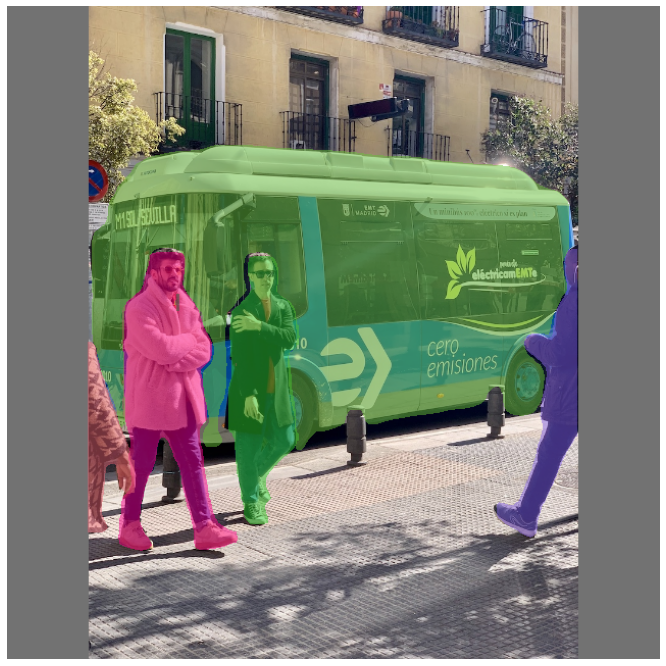

In [37]:
# coco example
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(pnimg)
plt.show()

# Mask has same shape with image + crop and resize to mask_resolution

In [81]:
pred, out = model(image)
proto = out[1]
pred.shape, proto.shape

(torch.Size([1, 25200, 117]), torch.Size([1, 32, 160, 160]))

In [82]:
conf_thres = 0.35
iou_thres = 0.65
max_det = 100

det = non_max_suppression(
    pred, conf_thres, iou_thres, None, False, max_det=max_det, nm=32
)[0]
print(det.shape)

torch.Size([6, 38])


In [83]:
det_bbox = det[:, :4]
det_conf = det[:, 4]
det_cls = det[:, 5]
det_mask = det[:, 6:]

det_bbox.shape, det_conf.shape, det_cls.shape, det_mask.shape

(torch.Size([6, 4]), torch.Size([6]), torch.Size([6]), torch.Size([6, 32]))

In [84]:
protos = proto[0].clone()
masks_in = det_mask.clone()
shape = image.shape[2:]
bboxes = det_bbox.clone()
print(shape)

c, mh, mw = protos.shape  # CHW
ih, iw = shape
masks = (masks_in @ protos.float().view(c, -1)).sigmoid().view(-1, mh, mw)  # CHW
print(masks.shape)

torch.Size([640, 640])
torch.Size([6, 160, 160])


In [85]:
downsampled_bboxes = bboxes.clone()
downsampled_bboxes[:, 0] *= mw / iw
downsampled_bboxes[:, 2] *= mw / iw
downsampled_bboxes[:, 3] *= mh / ih
downsampled_bboxes[:, 1] *= mh / ih
print(downsampled_bboxes.shape)

boxes = downsampled_bboxes

# Crop
n, h, w = masks.shape
x1, y1, x2, y2 = torch.chunk(boxes[:, :, None], 4, 1)  # x1 shape(1,1,n)
r = torch.arange(w, device=masks.device, dtype=x1.dtype)[
    None, None, :
]  # rows shape(1,w,1)
c = torch.arange(h, device=masks.device, dtype=x1.dtype)[
    None, :, None
]  # cols shape(h,1,1)
masks = masks * ((r >= x1) * (r < x2) * (c >= y1) * (c < y2))
print(masks.shape)

# Upsample
masks = F.interpolate(masks[None], shape, mode="bilinear", align_corners=False)[
    0
]  # CHW
print(masks.shape)

torch.Size([6, 4])
torch.Size([6, 160, 160])
torch.Size([6, 640, 640])


In [86]:
det_cls, det_conf = (
    det_cls.cpu().numpy(),
    det_conf.cpu().numpy(),
)

In [87]:
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

In [88]:
pnimg = nimg.copy()
print(pnimg.shape)

(640, 640, 3)


In [92]:
from torchvision.models.detection.roi_heads import paste_mask_in_image

for one_mask, bbox, cls, conf in zip(masks, det_bbox, det_cls, det_conf):
    if conf < 0.25:
        continue

    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax = (
        torch.round(max(xmin, 0)).to(torch.int32),
        torch.round(max(ymin, 0)).to(torch.int32),
        torch.round(min(xmax, 640 - 1)).to(torch.int32),
        torch.round(min(ymax, 640 - 1)).to(torch.int32),
    )

    mask = one_mask[..., ymin:ymax, xmin:xmax]

    one_mask = (
        paste_mask_in_image(mask, (xmin, ymin, xmax, ymax), 640, 640)
        .gt_(0.5)
        .cpu()
        .numpy()
        .astype(np.bool)
    )

    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5

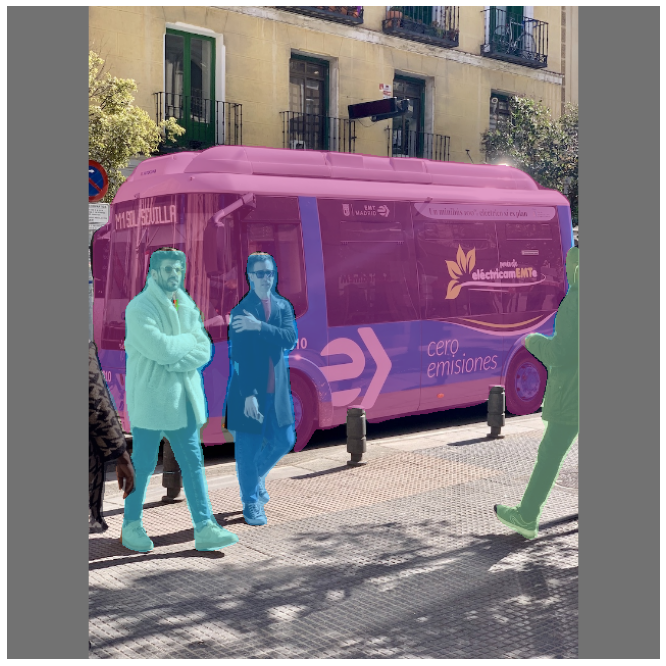

In [93]:
# coco example
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(pnimg)
plt.show()

# Using RoiAlign

In [101]:
pred, out = model(image)
proto = out[1]
pred.shape, proto.shape

(torch.Size([1, 25200, 117]), torch.Size([1, 32, 160, 160]))

In [102]:
conf_thres = 0.35
iou_thres = 0.65
max_det = 100

det = non_max_suppression(
    pred, conf_thres, iou_thres, None, False, max_det=max_det, nm=32
)[0]
print(det.shape)

torch.Size([6, 38])


In [103]:
det_bbox = det[:, :4]
det_conf = det[:, 4]
det_cls = det[:, 5]
det_mask = det[:, 6:]

det_bbox.shape, det_conf.shape, det_cls.shape, det_mask.shape

(torch.Size([6, 4]), torch.Size([6]), torch.Size([6]), torch.Size([6, 32]))

In [106]:
mask_resolution = 56

In [107]:
from torchvision.ops import roi_pool, roi_align

# test2_pooled_proto = roi_pool(
#     proto, outputs[:, :5], (mask_resolution, mask_resolution), 0.25
# )
# test2_pooled_proto.shape

pooled_proto = roi_align(
    proto.float(),
    [det_bbox.float()],
    (mask_resolution, mask_resolution),
    0.25,
    sampling_ratio=-1,
    aligned=True,
)
pooled_proto.shape

torch.Size([6, 32, 56, 56])

In [108]:
masks = det_mask.view(-1, 1, 32) @ pooled_proto.view(
    -1, 32, mask_resolution * mask_resolution
)
masks = (
    masks.view(-1, mask_resolution * mask_resolution)
    .view(-1, mask_resolution, mask_resolution)
    .sigmoid()
)
masks.shape, masks.min(), masks.max()

(torch.Size([6, 56, 56]),
 tensor(2.57800e-07, device='cuda:0'),
 tensor(0.99960, device='cuda:0'))

In [109]:
from torchvision.models.detection.roi_heads import paste_masks_in_image

pred_masks = paste_masks_in_image(
    masks.reshape(-1, 1, mask_resolution, mask_resolution), det_bbox, (640, 640)
)
pred_masks[pred_masks < 0.5] = 0
pred_masks[pred_masks > 0.5] = 1

pred_masks = pred_masks.reshape(-1, 640, 640)
pred_masks.shape

torch.Size([6, 640, 640])

In [110]:
masks, det_bbox, det_cls, det_conf = (
    pred_masks.cpu().numpy(),
    det_bbox.cpu().numpy(),
    det_cls.cpu().numpy(),
    det_conf.cpu().numpy(),
)
masks = masks.astype(np.bool)

In [111]:
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

In [112]:
pnimg = nimg.copy()
print(pnimg.shape)

(640, 640, 3)


In [113]:
for one_mask, bbox, cls, conf in zip(masks, det_bbox, det_cls, det_conf):
    if conf < 0.25:
        continue

    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5

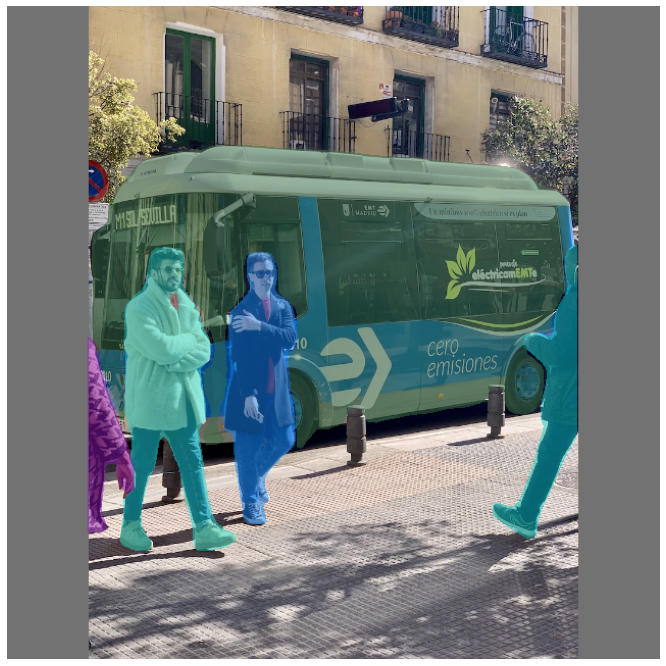

In [114]:
# coco example
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(pnimg)
plt.show()